# context

Notebook is modified version of [`Alphafold2_advanced`](https://github.com/sokrypton/ColabFold) for the [2Y69 heterodimer](https://www.rcsb.org/structure/2y69)  for a group project for the 2022 Spring Semester course Computational Genomics (CBMF W4761) at Columbia University.

- [Dylan Marshall](dmm2269@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Julia Urban](jau2112@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Peiwen Cai](pc2976@cumc.columbia.edu), Columbia Systems Biology PhD student

# modified advanced AF2

This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) (**before AlphaFold-Multimer existed**) to add experimental support for modeling complexes (both homo and hetero-oligomers), option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See [ColabFold](https://github.com/sokrypton/ColabFold/) for other related notebooks

**Limitations**
- This notebook does **NOT** use Templates.
- This notebook does **NOT** use AlphaFold-Multimer for complex (protein-protein) modeling.
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **1400 residues**. Sometimes a `12G-GPU` is assigned, in which the max length is ~1000 residues.
- Can I use the models for **Molecular Replacement**? Yes, but be CAREFUL, the bfactor column is populated with pLDDT confidence values (higher = better). Phenix.phaser expects a "real" bfactor, where (lower = better). See [post](https://twitter.com/cheshireminima/status/1423929241675120643) from Claudia Millán on how to process models.

In [1]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

# setup device
import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook

install_jackhmmer = True
GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")

    # download colabfold patches
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold_alphafold.py")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/pairmsa.py")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/protein.patch -P {TMP_DIR}")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/config.patch -P {TMP_DIR}")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/model.patch -P {TMP_DIR}")
    os.system(f"wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/modules.patch -P {TMP_DIR}")

    # apply patch to dynamically control number of recycles (idea from Ryan Kibler)
    os.system(f"patch -u alphafold/alphafold/model/model.py -i {TMP_DIR}/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i {TMP_DIR}/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i {TMP_DIR}/config.patch")

    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i {TMP_DIR}/protein.patch")
    pbar.update(4)

    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

########################################################################################
# --- Python imports ---
if '/content/alphafold' not in sys.path:
  sys.path.append('/content/alphafold')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

Running on GPU


  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

**UniProt sourced FASTA sequences**


In [2]:
upA = "MNKVITDLDKALSALKDGDTILVGGFGLCGIPEYAIDYIYKKGIKDLIVVSNNCGVDDFGLGILLEKKQIKKIIASYVGENKIFESQMLNGEIEVVLTPQGTLAENLHAGGAGIPAYYTPTGVGTLIAQGKESREFNGKEYILERAITGDYGLIKAYKSDTLGNLVFRKTARNFNPLCAMAAKICVAEVEEIVPAGELDPDEIHLPGIYVQHIYKGEKFEKRIEKITTRSTK"
upB = "MREAIIKRAAKELKEGMYVNLGIGLPTLVANEVSGMNIVFQSENGLLGIGAYPLEGSVDADLINAGKETITVVPGASFFNSADSFAMIRGGHIDLAILGGMEVSQNGDLANWMIPKKLIKGMGGAMDLVHGAKKVIVIMEHCNKYGESKVKKECSLPLTGKGVVHQLITDLAVFEFSNNAMKLVELQEGVSLDQVKEKTEAEFEVRL"

In [3]:
print(":".join([upA, upB]))

MNKVITDLDKALSALKDGDTILVGGFGLCGIPEYAIDYIYKKGIKDLIVVSNNCGVDDFGLGILLEKKQIKKIIASYVGENKIFESQMLNGEIEVVLTPQGTLAENLHAGGAGIPAYYTPTGVGTLIAQGKESREFNGKEYILERAITGDYGLIKAYKSDTLGNLVFRKTARNFNPLCAMAAKICVAEVEEIVPAGELDPDEIHLPGIYVQHIYKGEKFEKRIEKITTRSTK:MREAIIKRAAKELKEGMYVNLGIGLPTLVANEVSGMNIVFQSENGLLGIGAYPLEGSVDADLINAGKETITVVPGASFFNSADSFAMIRGGHIDLAILGGMEVSQNGDLANWMIPKKLIKGMGGAMDLVHGAKKVIVIMEHCNKYGESKVKKECSLPLTGKGVVHQLITDLAVFEFSNNAMKLVELQEGVSLDQVKEKTEAEFEVRL


In [5]:
#@title Enter the amino acid sequence to fold ⬇️
import re

# define sequence
sequence = 'MNKVITDLDKALSALKDGDTILVGGFGLCGIPEYAIDYIYKKGIKDLIVVSNNCGVDDFGLGILLEKKQIKKIIASYVGENKIFESQMLNGEIEVVLTPQGTLAENLHAGGAGIPAYYTPTGVGTLIAQGKESREFNGKEYILERAITGDYGLIKAYKSDTLGNLVFRKTARNFNPLCAMAAKICVAEVEEIVPAGELDPDEIHLPGIYVQHIYKGEKFEKRIEKITTRSTK:MREAIIKRAAKELKEGMYVNLGIGLPTLVANEVSGMNIVFQSENGLLGIGAYPLEGSVDADLINAGKETITVVPGASFFNSADSFAMIRGGHIDLAILGGMEVSQNGDLANWMIPKKLIKGMGGAMDLVHGAKKVIVIMEHCNKYGESKVKKECSLPLTGKGVVHQLITDLAVFEFSNNAMKLVELQEGVSLDQVKEKTEAEFEVRL' #@param {type:"string"}
jobname = "3RRL" #@param {type:"string"}
homooligomer =  "1" #@param {type:"string"}

#@markdown - `sequence` Specify protein sequence to be modelled.
#@markdown  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
#@markdown  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
#@markdown  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.
#@markdown    If `pair_msa` is enabled, `ACDE`'s MSA will be paired with `FGH`'s MSA.
#@markdown - `homooligomer` Define number of copies in a homo-oligomeric assembly.
#@markdown  - Use `:` to specify different homooligomeric state (copy numer) for each component of the complex. 
#@markdown  - For example, **sequence:**`ABC:DEF`, **homooligomer:** `2:1`, the first protein `ABC` will be modeled as a homodimer (2 copies) and second `DEF` a monomer (1 copy).

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)

homooligomer: 1:1
total_length: 439
output_dir: prediction_3RRL_baea4


attempting to pair some sequences...
running mmseqs2_noenv_nofilter on all seqs


  0%|          | 0/300 [elapsed: 00:00 remaining: ?]

prepping seq_0
prepping seq_1
attempting pairwise stitch for 0 1


  0%|          | 0/50684 [elapsed: 00:00 remaining: ?]

found 5508 pairs (3422 after filtering)


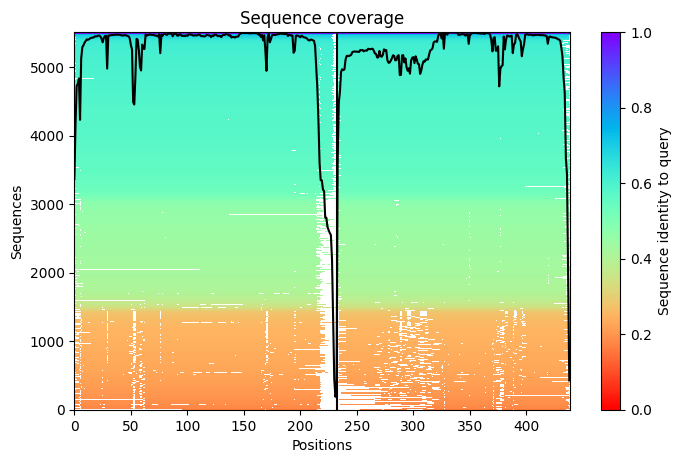

In [6]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
#@markdown - `single_sequence` - use single sequence input
#@markdown - `precomputed` If you have previously run this notebook and saved the results,
#@markdown you can skip this step by uploading 
#@markdown the previously generated  `prediction_?????/msa.pickle`


#@markdown ---
#@markdown **custom msa options**
add_custom_msa = False #@param {type:"boolean"}
msa_format = "fas" #@param ["fas","a2m","a3m","sto","psi","clu"]
#@markdown - `add_custom_msa` - If enabled, you'll get an option to upload your custom MSA in the specified `msa_format`. Note: Your MSA will be supplemented with those from 'mmseqs2' or 'jackhmmer', unless `msa_method` is set to 'single_sequence'.

#@markdown ---
#@markdown **pair msa options**

#@markdown Experimental option for protein complexes. Pairing currently only supported for proteins in same operon (prokaryotic genomes).
pair_mode = "paired" #@param ["unpaired","unpaired+paired","paired"] {type:"string"}
#@markdown - `unpaired` - generate seperate MSA for each protein.
#@markdown - `unpaired+paired` - attempt to pair sequences from the same operon within the genome. 
#@markdown - `paired` - only use sequences that were sucessfully paired.

#@markdown Options to prefilter each MSA before pairing. (It might help if there are any paralogs in the complex.)
pair_cov = 50 #@param [0,25,50,75,90] {type:"raw"}
pair_qid = 20 #@param [0,15,20,30,40,50] {type:"raw"}
#@markdown - `pair_cov` prefilter each MSA to minimum coverage with query (%) before pairing.
#@markdown - `pair_qid` prefilter each MSA to minimum sequence identity with query (%) before pairing.

# --- Search against genetic databases ---

I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I

if len(I["msas"][0]) > 1:
  plt = cf.plot_msas(I["msas"], I["ori_sequence"])
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [ ]:
#@title Run alphafold
num_relax = "None"
rank_by = "pLDDT" #@param ["pLDDT","pTMscore"]
use_turbo = True #@param {type:"boolean"}
max_msa = "512:1024" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64"]
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

#@markdown - `rank_by` specify metric to use for ranking models (For protein-protein complexes, we recommend pTMscore)
#@markdown - `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior.
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. When adjusting after GPU crash, be sure to `Runtime` → `Restart runtime`. (Lowering will reduce GPU requirements, but may result in poor model quality. This option ignored if `use_turbo` is disabled)
show_images = True #@param {type:"boolean"}
#@markdown - `show_images` To make things more exciting we show images of the predicted structures as they are being generated. (WARNING: the order of images displayed does not reflect any ranking).

#@markdown ---
#@markdown **sampling options**

#@markdown There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout). 
#@markdown To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).

num_models = 1 #@param [1,2,3,4,5] {type:"raw"}
use_ptm = True #@param {type:"boolean"}
num_ensemble = 1 #@param [1,8] {type:"raw"}
max_recycles = 3 #@param [0,1,3,6,12,24,48] {type:"raw"}
tol = 0 #@param [0,0.1,0.5,1] {type:"raw"}
is_training = False #@param {type:"boolean"}
num_samples = 1 #@param [1,2,4,8,16,32] {type:"raw"}
#@markdown - `num_models` specify how many model params to try. (5 recommended)
#@markdown - `use_ptm` uses Deepmind's `ptm` finetuned model parameters to get PAE per structure. Disable to use the original model params. (Disabling may give alternative structures.)
#@markdown - `num_ensemble` the trunk of the network is run multiple times with different random choices for the MSA cluster centers. (`1`=`default`, `8`=`casp14 setting`)
#@markdown - `max_recycles` controls the maximum number of times the structure is fed back into the neural network for refinement. (3 recommended)
#@markdown  - `tol` tolerance for deciding when to stop (CA-RMS between recycles)
#@markdown - `is_training` enables the stochastic part of the model (dropout), when coupled with `num_samples` can be used to "sample" a diverse set of structures.
#@markdown - `num_samples` number of random_seeds to try.
subsample_msa = True #@param {type:"boolean"}
#@markdown - `subsample_msa` subsample large MSA to `3E7/length` sequences to avoid crashing the preprocessing protocol. (This option ignored if `use_turbo` is disabled.)

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":tol,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

if use_turbo:
  if "runner" in dir():
    # only recompile if options changed
    runner = cf_af.prep_model_runner(opt, old_runner=runner)
  else:
    runner = cf_af.prep_model_runner(opt)
else:
  runner = None

###########################
# run alphafold
###########################
outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images)


  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

In [8]:
#@title Refine structures with Amber-Relax (optional)
#@markdown If side-chain bond geometry is important to you, enable Amber-Relax by specifying how many top ranked structures you want relaxed. By default, we disable Amber-Relax since it barely moves the main-chain (backbone) structure and can overall double the runtime.
num_relax = "Top1" #@param ["None", "Top1", "Top5", "All"] {type:"string"}
if num_relax == "None":
  num_relax = 0
elif num_relax == "Top1":
  num_relax = 1
elif num_relax == "Top5":
  num_relax = 5
else:
  num_relax = num_models * num_samples

#@markdown - `num_relax` specify how many of the top ranked structures to relax
if num_relax > 0 and not os.path.isfile("stereo_chemical_props.txt"):
  try:
    total = 45
    with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
      pbar.set_description(f'INSTALL AMBER')
      with io.capture_output() as captured:
        # Install OpenMM and pdbfixer.
        %shell rm -rf /opt/conda
        %shell wget -q -P /tmp \
          https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
            && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
            && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
        pbar.update(4)

        PATH=%env PATH
        %env PATH=/opt/conda/bin:{PATH}
        %shell conda update -qy conda \
            && conda install -qy -c conda-forge \
              python=3.7 \
              openmm=7.5.1 \
              pdbfixer
        pbar.update(40)

        %shell wget -q -P /content \
          https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
        pbar.update(1)
        %shell mkdir -p /content/alphafold/common
        %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

        # Apply OpenMM patch.
        %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
            patch -p0 < /content/alphafold/docker/openmm.patch && \
            popd

  except subprocess.CalledProcessError:
    print(captured)
    raise

if num_relax > 0:
  if "relax" not in dir():
    # add conda environment to path
    sys.path.append('/opt/conda/lib/python3.7/site-packages')
    
    # import libraries
    from alphafold.relax import relax
    from alphafold.relax import utils

  with tqdm.notebook.tqdm(total=num_relax, bar_format=TQDM_BAR_FORMAT) as pbar:
    pbar.set_description(f'AMBER relaxation')
    for n,key in enumerate(model_rank):
      if n < num_relax:
        prefix = f"rank_{n+1}_{key}" 
        pred_output_path = os.path.join(I["output_dir"],f'{prefix}_relaxed.pdb')
        if not os.path.isfile(pred_output_path):
          amber_relaxer = relax.AmberRelaxation(
              max_iterations=0,
              tolerance=2.39,
              stiffness=10.0,
              exclude_residues=[],
              max_outer_iterations=20)
          relaxed_pdb_lines, _, _ = amber_relaxer.process(prot=outs[key]["unrelaxed_protein"])        
          with open(pred_output_path, 'w') as f:
            f.write(relaxed_pdb_lines)
        pbar.update(n=1)

  0%|          | 0/45 [elapsed: 00:00 remaining: ?]

  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

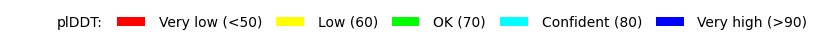

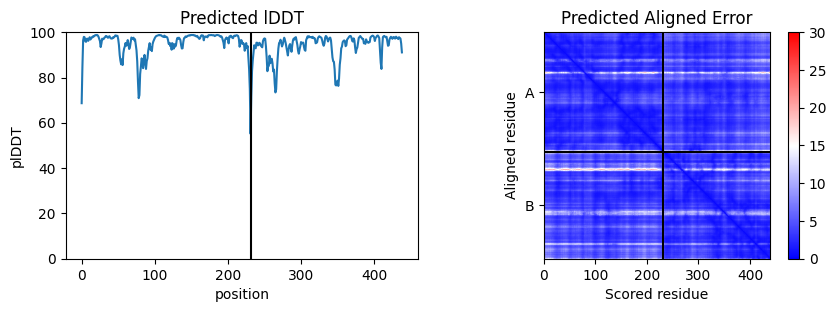

In [9]:
#@title Display 3D structure (optional) {run: "auto"}
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

key = model_rank[rank_num-1]
prefix = f"rank_{rank_num}_{key}" 
pred_output_path = os.path.join(I["output_dir"],f'{prefix}_relaxed.pdb')  
if not os.path.isfile(pred_output_path):
  pred_output_path = os.path.join(I["output_dir"],f'{prefix}_unrelaxed.pdb') 

cf.show_pdb(pred_output_path, show_sidechains, show_mainchains, color, Ls=Ls_plot).show()
if color == "lDDT": cf.plot_plddt_legend().show()  
if use_ptm:
  cf.plot_confidence(outs[key]["plddt"], outs[key]["pae"], Ls=Ls_plot).show()
else:
  cf.plot_confidence(outs[key]["plddt"], Ls=Ls_plot).show()

In [10]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# add settings file
settings_path = os.path.join(I["output_dir"],"settings.txt")
with open(settings_path, "w") as text_file:
  text_file.write(f"notebook=https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced_beta.ipynb\n")
  text_file.write(f"sequence={I['ori_sequence']}\n")
  text_file.write(f"msa_method={msa_method}\n")
  if add_custom_msa:
    text_file.write(f"add_custom_msa={add_custom_msa} msa_format={msa_format}\n")
  text_file.write(f"homooligomer={I['homooligomer']}\n")

  text_file.write(f"pair_mode={pair_mode}\n")
  if pair_mode != "unpaired":
    text_file.write(f"pair_cov={pair_cov}\n")
    text_file.write(f"pair_qid={pair_qid}\n")
  
  if I["ori_sequence"] != mod_I["ori_sequence"]:
    text_file.write(f"mod_sequence={mod_I['ori_sequence']}\n")
    text_file.write(f"trim={trim}\n")
    text_file.write(f"trim_inverse={trim_inverse}\n")
  
  if "cov" in dir():
    text_file.write(f"cov={cov}\n")
    text_file.write(f"qid={qid}\n")
  else:
    text_file.write(f"cov=0\nqid=0\n")

  text_file.write(f"max_msa={max_msa}\n")
  text_file.write(f"subsample_msa={subsample_msa}\n")  
  text_file.write(f"num_relax={num_relax}\n")
  text_file.write(f"use_turbo={use_turbo}\n")
  text_file.write(f"use_ptm={use_ptm}\n")
  text_file.write(f"rank_by={rank_by}\n")
  text_file.write(f"num_models={num_models}\n")
  text_file.write(f"num_samples={num_samples}\n")
  text_file.write(f"num_ensemble={num_ensemble}\n")
  text_file.write(f"max_recycles={max_recycles}\n")
  text_file.write(f"tol={tol}\n")
  text_file.write(f"is_training={is_training}\n")
  text_file.write(f"use_templates=False\n")
  text_file.write(f"-------------------------------------------------\n")

  for n,key in enumerate(model_rank):
    line = f"rank_{n+1}_{key} pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    text_file.write(line+"\n")

# --- Download the predictions ---
%shell zip -FSr {I["output_dir"]}.zip {I["output_dir"]}
if IN_COLAB:
  files.download(f'{I["output_dir"]}.zip')
else:
  print("this notebook appears to be running locally, to download click folder icon to the left, navigate to file, right click and download")

  adding: prediction_3RRL_baea4/ (stored 0%)
  adding: prediction_3RRL_baea4/rank_1_model_1_ptm_seed_0.png (deflated 2%)
  adding: prediction_3RRL_baea4/rank_1_model_1_ptm_seed_0_relaxed.pdb (deflated 78%)
  adding: prediction_3RRL_baea4/msa.pickle (deflated 90%)
  adding: prediction_3RRL_baea4/settings.txt (deflated 34%)
  adding: prediction_3RRL_baea4/msa_coverage.png (deflated 5%)
  adding: prediction_3RRL_baea4/rank_1_model_1_ptm_seed_0_unrelaxed.pdb (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Distances 

In [11]:
%%capture
!pip install biopandas

In [12]:
import seaborn as sns
from biopandas.pdb import PandasPdb
from scipy.spatial.distance import pdist, squareform

In [13]:
def pdb2dm(pdb): return squareform(pdist(pdb[["x_coord", "y_coord", "z_coord"]].values), force="tomatrix")

In [14]:
def inter2list(i): return "["+", ".join(["["+i+", "+j+"]" for i, j in zip(*i.astype("str").T)])+"]"

In [16]:
pred = PandasPdb().read_pdb("prediction_3RRL_baea4/rank_1_model_1_ptm_seed_0_relaxed.pdb").df["ATOM"]
dm = pdb2dm(pred[pred["atom_name"] == "CA"])
interface = dm[:len(upA), len(upA):]

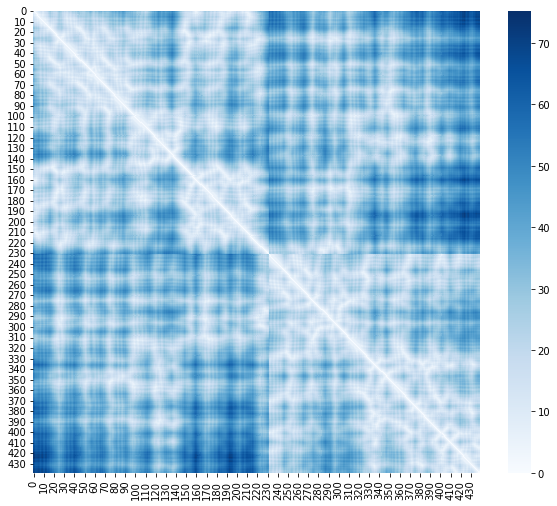

In [17]:
F, A = plt.subplots(1, 1, figsize=(10, 8.5))
sns.heatmap(dm, cmap="Blues", ax=A)
plt.show();

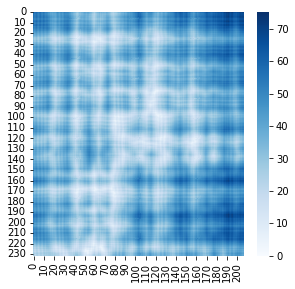

In [18]:
F, A = plt.subplots(1, 1, figsize=(10*interface.shape[1]/len(dm), 8.5*interface.shape[0]/len(dm)))
sns.heatmap(interface, vmin=dm.min(), vmax=dm.max(), cmap="Blues", ax=A)
plt.show();

In [19]:
i5 = np.argwhere(interface <= 5)
print(inter2list(i5))

[[76, 120], [78, 119], [99, 123], [103, 81], [172, 79], [172, 80], [224, 67]]


In [20]:
i10 = np.argwhere(interface <= 10)
print(inter2list(i10))

[[24, 43], [24, 60], [24, 80], [25, 43], [25, 44], [25, 60], [25, 62], [25, 63], [25, 64], [25, 66], [25, 80], [26, 43], [26, 62], [26, 64], [26, 65], [26, 66], [27, 59], [27, 60], [27, 62], [27, 66], [28, 43], [28, 58], [28, 59], [28, 60], [28, 61], [28, 62], [28, 63], [28, 66], [29, 59], [29, 60], [29, 61], [51, 43], [51, 80], [51, 122], [52, 120], [52, 122], [74, 120], [74, 121], [74, 122], [75, 119], [75, 120], [75, 121], [75, 122], [75, 123], [76, 111], [76, 118], [76, 119], [76, 120], [76, 121], [76, 122], [76, 123], [77, 118], [77, 119], [77, 120], [77, 121], [77, 122], [78, 117], [78, 118], [78, 119], [78, 120], [79, 119], [84, 117], [84, 118], [84, 119], [87, 118], [88, 115], [88, 116], [88, 118], [95, 120], [96, 118], [96, 119], [96, 120], [96, 121], [96, 122], [97, 120], [97, 121], [97, 122], [97, 123], [97, 125], [98, 120], [98, 121], [98, 122], [98, 123], [98, 124], [98, 125], [98, 126], [98, 158], [99, 42], [99, 43], [99, 80], [99, 81], [99, 84], [99, 120], [99, 121], [99

# License

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and  [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).